In [1]:
# Runtime > Change runtime type > GPU seç (varsa)

!pip -q install pandas numpy scikit-learn matplotlib tqdm
!pip -q install torch torchvision torchaudio
!pip -q install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cu121.html
!pip -q install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.5 MB/s eta 0:00:00


In [2]:
import torch, torch_geometric
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available(), "pyg:", torch_geometric.__version__)


/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/libpyg.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sp

torch: 2.9.0+cpu cuda: False pyg: 2.7.0


In [3]:
from google.colab import files
uploaded = files.upload()  # "Derin Öğrenme ve Uygulamaları Veri Seti.xlsx" seç


Saving Derin Öğrenme ve Uygulamaları Veri Seti.xlsx to Derin Öğrenme ve Uygulamaları Veri Seti.xlsx


In [5]:
import pandas as pd
import numpy as np

# Veriyi tekrar oku (emin olmak için)
df = pd.read_excel(fname)

def extract_hour(x):
    if pd.isna(x):
        return np.nan
    if hasattr(x, "hour"):          # datetime.time
        return x.hour
    try:                             # string veya int
        return int(str(x).split(":")[0])
    except:
        return np.nan

df["hour"] = df["Saat"].apply(extract_hour)

# Saat NaN olan satırları temizle (çok az olur, güvenli)
df = df.dropna(subset=["hour"]).reset_index(drop=True)

df["hour"] = df["hour"].astype(int)

# datetime oluştur
df["datetime"] = pd.to_datetime(df["Tarih"]) + pd.to_timedelta(df["hour"], unit="h")
df = df.sort_values("datetime").reset_index(drop=True)

print("Temizlenmiş veri boyutu:", df.shape)
df[["Tarih","Saat","hour","datetime"]].head(10)


Temizlenmiş veri boyutu: (1464, 15)


,Tarih,Saat,hour,datetime
0,2024-11-10,00:00:00,0,2024-11-10 00:00:00
1,2024-11-10,06:00:00,6,2024-11-10 06:00:00
2,2024-11-10,12:00:00,12,2024-11-10 12:00:00
3,2024-11-10,18:00:00,18,2024-11-10 18:00:00
4,2024-11-11,00:00:00,0,2024-11-11 00:00:00
5,2024-11-11,06:00:00,6,2024-11-11 06:00:00
6,2024-11-11,12:00:00,12,2024-11-11 12:00:00
7,2024-11-11,18:00:00,18,2024-11-11 18:00:00
8,2024-11-12,00:00:00,0,2024-11-12 00:00:00
9,2024-11-12,06:00:00,6,2024-11-12 06:00:00


In [6]:
cand = [c for c in df.columns if str(c).upper() in ["PTF","SMF"]]
print("Found targets:", cand)


Found targets: []


In [7]:
print(df.columns.tolist())


['Tarih', 'Saat', 'Hidroelektrik (HES)', 'Rüzgar (RES)', 'Güneş (GES)', 'Jeotermal (JES)', 'Biyokütle/Biyogaz', 'Doğalgaz', 'Kömür', 'Sıvı Yakıt', 'Sıvılaştırılmış Gaz', 'ptf_fiyat', 'smf_fiyat', 'hour', 'datetime']


In [8]:
import re

# Kolon adlarını normalize et (boşluk, parantez, noktalama vs.)
norm_map = {}
for c in df.columns:
    cc = str(c).strip()
    cc_norm = re.sub(r"\s+", " ", cc)  # çoklu boşlukları tek boşluk yap
    norm_map[c] = cc_norm

df = df.rename(columns=norm_map)

# İçerik araması: içinde PTF veya SMF geçen kolonları bul
cands = []
for c in df.columns:
    up = str(c).upper().replace("İ","I")  # TR-EN farkına küçük önlem
    if "PTF" in up or "SMF" in up:
        cands.append(c)

print("Target candidates:", cands)


Target candidates: ['ptf_fiyat', 'smf_fiyat']


In [9]:
import pandas as pd
import numpy as np

TARGET_COL = "ptf_fiyat"   # önce PTF

GEN_COLS = [
    'Hidroelektrik (HES)', 'Rüzgar (RES)', 'Güneş (GES)', 'Jeotermal (JES)',
    'Biyokütle/Biyogaz', 'Doğalgaz', 'Kömür', 'Sıvı Yakıt', 'Sıvılaştırılmış Gaz'
]

# numeric + temizle
df[GEN_COLS] = df[GEN_COLS].apply(pd.to_numeric, errors="coerce").fillna(0.0).clip(lower=0.0)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

df = df.dropna(subset=[TARGET_COL]).reset_index(drop=True)

print("Rows:", len(df))
print("Target:", TARGET_COL, "min/max:", df[TARGET_COL].min(), df[TARGET_COL].max())


Rows: 1464
Target: ptf_fiyat min/max: 0.0 3400.0


In [10]:
df["dow"] = df["datetime"].dt.dayofweek
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)
TIME_COLS = ["hour_sin","hour_cos","dow_sin","dow_cos"]

split = int(len(df)*0.8)
train_df = df.iloc[:split].reset_index(drop=True)
test_df  = df.iloc[split:].reset_index(drop=True)
print("train:", train_df.shape, "test:", test_df.shape)


train: (1171, 20) test: (293, 20)


Baseline Ridge -> RMSE: 613.6513261710746 | MAE: 481.57834107650115 | R2: -0.037603708131292324


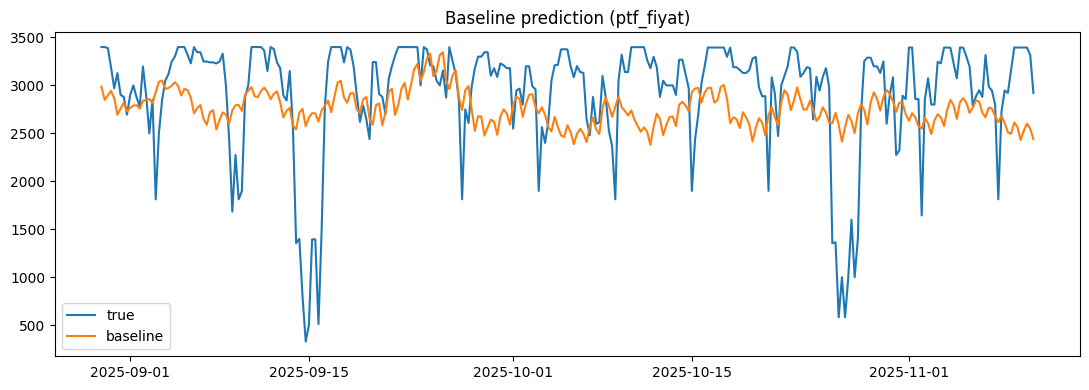

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

Xtr = train_df[GEN_COLS + TIME_COLS].values
ytr = train_df[TARGET_COL].values

Xte = test_df[GEN_COLS + TIME_COLS].values
yte = test_df[TARGET_COL].values

base = Ridge(alpha=1.0)
base.fit(Xtr, ytr)
pred_base = base.predict(Xte)

mse  = mean_squared_error(yte, pred_base)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(yte, pred_base)
r2   = r2_score(yte, pred_base)

print("Baseline Ridge -> RMSE:", rmse, "| MAE:", mae, "| R2:", r2)

plt.figure(figsize=(11,4))
plt.plot(test_df["datetime"], yte, label="true")
plt.plot(test_df["datetime"], pred_base, label="baseline")
plt.title(f"Baseline prediction ({TARGET_COL})")
plt.legend(); plt.tight_layout(); plt.show()


In [14]:
import torch
from torch_geometric.data import Data

L = 24  # geçmiş pencere (istersen 48 yap)

num_nodes = len(GEN_COLS)
edges = [[i,j] for i in range(num_nodes) for j in range(num_nodes)]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

def make_graph_samples(frame):
    data_list = []
    for t in range(L, len(frame)):
        hist = frame.iloc[t-L:t]

        x_list = []
        for c in GEN_COLS:
            seq = hist[c].values.astype(np.float32)                  # (L,)
            tf  = hist[TIME_COLS].iloc[-1].values.astype(np.float32) # (4,)
            x_list.append(np.concatenate([seq, tf]))                 # (L+4,)

        x = torch.tensor(np.stack(x_list), dtype=torch.float32)      # (nodes, L+4)
        y = torch.tensor([frame.iloc[t][TARGET_COL]], dtype=torch.float32)  # (1,)
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    return data_list

train_ds = make_graph_samples(train_df)
test_ds  = make_graph_samples(test_df)

print("train graphs:", len(train_ds), "test graphs:", len(test_ds))


train graphs: 1147 test graphs: 269


device: cpu
Epoch 01 | train_loss 12832777.5694 | RMSE 1049.45 MAE 870.10 R2 -1.863
Epoch 05 | train_loss 2957857.0000 | RMSE 813.33 MAE 707.52 R2 -0.720
Epoch 10 | train_loss 2911617.0833 | RMSE 812.02 MAE 677.25 R2 -0.714
Epoch 15 | train_loss 2617964.6181 | RMSE 686.24 MAE 578.08 R2 -0.224
Epoch 20 | train_loss 1576894.8333 | RMSE 1459.45 MAE 1344.78 R2 -4.537


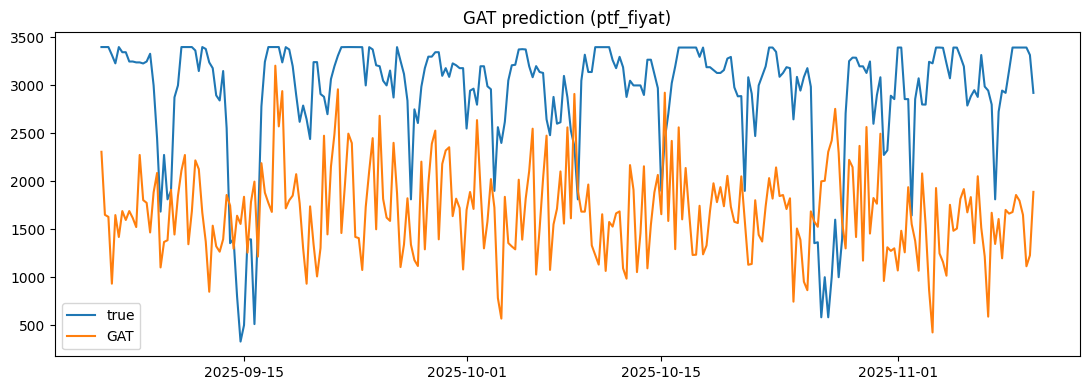

In [15]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

class GATPrice(torch.nn.Module):
    def __init__(self, in_dim, hid=64, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_dim, hid, heads=heads, dropout=0.2)
        self.gat2 = GATConv(hid*heads, hid, heads=1, dropout=0.2)
        self.lin  = torch.nn.Linear(hid, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        g = global_mean_pool(x, batch)
        return self.lin(g).squeeze(-1)

model = GATPrice(in_dim=L+4).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def run_eval(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            p = model(data)
            ys.append(data.y.squeeze(-1).detach().cpu().numpy())
            ps.append(p.detach().cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)

EPOCHS = 20
for ep in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for data in train_loader:
        data = data.to(device)
        opt.zero_grad()
        p = model(data)
        loss = F.mse_loss(p, data.y.squeeze(-1))
        loss.backward()
        opt.step()
        total += loss.item()

    if ep % 5 == 0 or ep == 1:
        y, p = run_eval(test_loader)
        mse  = mean_squared_error(y, p)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y, p)
        r2   = r2_score(y, p)
        print(f"Epoch {ep:02d} | train_loss {total/len(train_loader):.4f} | RMSE {rmse:.2f} MAE {mae:.2f} R2 {r2:.3f}")

# Final plot
y, p = run_eval(test_loader)

plt.figure(figsize=(11,4))
plt.plot(test_df["datetime"].iloc[L:], y, label="true")
plt.plot(test_df["datetime"].iloc[L:], p, label="GAT")
plt.title(f"GAT prediction ({TARGET_COL})")
plt.legend(); plt.tight_layout(); plt.show()


Normalizasyon

In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) önceki fiyat (lag)
df["prev_price"] = df[TARGET_COL].shift(1)
df = df.dropna(subset=["prev_price"]).reset_index(drop=True)

# time split'i yeniden kur (shift yüzünden 1 satır gitti)
split = int(len(df)*0.8)
train_df = df.iloc[:split].reset_index(drop=True)
test_df  = df.iloc[split:].reset_index(drop=True)

# 2) scaler: sadece train ile fit (doğru yöntem)
x_scaler = StandardScaler()
y_scaler = StandardScaler()

train_X_raw = train_df[GEN_COLS + TIME_COLS + ["prev_price"]].values
test_X_raw  = test_df[GEN_COLS + TIME_COLS + ["prev_price"]].values

train_y_raw = train_df[[TARGET_COL]].values
test_y_raw  = test_df[[TARGET_COL]].values

x_scaler.fit(train_X_raw)
y_scaler.fit(train_y_raw)

train_X = x_scaler.transform(train_X_raw)
test_X  = x_scaler.transform(test_X_raw)

train_y = y_scaler.transform(train_y_raw).reshape(-1)
test_y  = y_scaler.transform(test_y_raw).reshape(-1)

print("OK: normalized + prev_price ready")


OK: normalized + prev_price ready


In [17]:
import torch
from torch_geometric.data import Data

L = 24  # pencere

num_nodes = len(GEN_COLS)
edges = [[i,j] for i in range(num_nodes) for j in range(num_nodes)]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

def make_graph_samples_from_scaled(frame_X, frame_y, frame_dt):
    data_list = []
    for t in range(L, len(frame_y)):
        # geçmiş pencere [t-L, ..., t-1]
        hist_X = frame_X[t-L:t]  # (L, feat_total)

        # hist_X içinde kolon sırası: GEN_COLS + TIME_COLS + prev_price
        # Biz node başına: [L üretim seq] + [time(4)] + [prev_price(1)]
        # time ve prev_price: t-1 satırından alıyoruz (son saat)
        last = hist_X[-1]
        time_feat = last[len(GEN_COLS):len(GEN_COLS)+len(TIME_COLS)]           # (4,)
        prev_p    = last[len(GEN_COLS)+len(TIME_COLS):len(GEN_COLS)+len(TIME_COLS)+1]  # (1,)

        x_list = []
        for i, c in enumerate(GEN_COLS):
            seq = hist_X[:, i].astype(np.float32)  # (L,) sadece o kaynağın geçmişi
            feat = np.concatenate([seq, time_feat.astype(np.float32), prev_p.astype(np.float32)])  # (L+4+1,)
            x_list.append(feat)

        x = torch.tensor(np.stack(x_list), dtype=torch.float32)  # (nodes, L+5)
        y = torch.tensor([frame_y[t]], dtype=torch.float32)      # scaled target
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    return data_list

train_dt = train_df["datetime"].values
test_dt  = test_df["datetime"].values

train_ds = make_graph_samples_from_scaled(train_X, train_y, train_dt)
test_ds  = make_graph_samples_from_scaled(test_X, test_y, test_dt)

print("train graphs:", len(train_ds), "test graphs:", len(test_ds))


train graphs: 1146 test graphs: 269


Epoch 01 | train_loss 0.6601 | RMSE 488.13 MAE 339.84 R2 0.381
Epoch 05 | train_loss 0.5087 | RMSE 459.64 MAE 321.07 R2 0.451
Epoch 10 | train_loss 0.4570 | RMSE 449.93 MAE 324.88 R2 0.474
Epoch 15 | train_loss 0.4395 | RMSE 455.27 MAE 343.04 R2 0.461
Epoch 20 | train_loss 0.4175 | RMSE 457.74 MAE 341.15 R2 0.455
Epoch 25 | train_loss 0.3728 | RMSE 461.89 MAE 341.34 R2 0.445


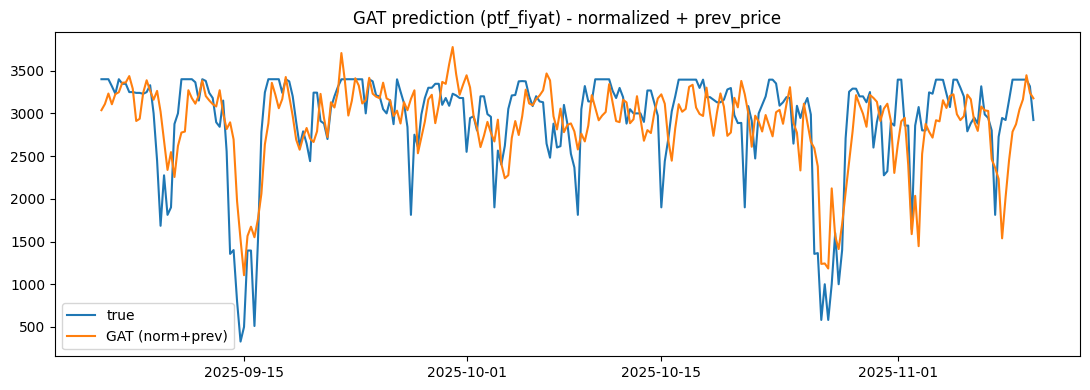

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

class GATPrice(torch.nn.Module):
    def __init__(self, in_dim, hid=64, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_dim, hid, heads=heads, dropout=0.2)
        self.gat2 = GATConv(hid*heads, hid, heads=1, dropout=0.2)
        self.lin  = torch.nn.Linear(hid, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        g = global_mean_pool(x, batch)
        return self.lin(g).squeeze(-1)

model = GATPrice(in_dim=L+5).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def run_eval(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            p = model(data)
            ys.append(data.y.squeeze(-1).detach().cpu().numpy())
            ps.append(p.detach().cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)

EPOCHS = 25
for ep in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for data in train_loader:
        data = data.to(device)
        opt.zero_grad()
        p = model(data)
        loss = F.mse_loss(p, data.y.squeeze(-1))
        loss.backward()
        opt.step()
        total += loss.item()

    if ep % 5 == 0 or ep == 1:
        y_s, p_s = run_eval(test_loader)
        # scaled -> gerçek fiyat
        y_real = y_scaler.inverse_transform(y_s.reshape(-1,1)).reshape(-1)
        p_real = y_scaler.inverse_transform(p_s.reshape(-1,1)).reshape(-1)

        mse = mean_squared_error(y_real, p_real)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_real, p_real)
        r2   = r2_score(y_real, p_real)
        print(f"Epoch {ep:02d} | train_loss {total/len(train_loader):.4f} | RMSE {rmse:.2f} MAE {mae:.2f} R2 {r2:.3f}")

# final plot
y_s, p_s = run_eval(test_loader)
y_real = y_scaler.inverse_transform(y_s.reshape(-1,1)).reshape(-1)
p_real = y_scaler.inverse_transform(p_s.reshape(-1,1)).reshape(-1)

plt.figure(figsize=(11,4))
plt.plot(test_df["datetime"].iloc[L:], y_real, label="true")
plt.plot(test_df["datetime"].iloc[L:], p_real, label="GAT (norm+prev)")
plt.title(f"GAT prediction ({TARGET_COL}) - normalized + prev_price")
plt.legend(); plt.tight_layout(); plt.show()


In [20]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader

num_nodes = len(GEN_COLS)

# test graph'ları tek tek gez
test_loader_1 = DataLoader(test_ds, batch_size=1, shuffle=False)

out_sum = np.zeros(num_nodes, dtype=np.float64)
out_cnt = np.zeros(num_nodes, dtype=np.float64)
in_sum  = np.zeros(num_nodes, dtype=np.float64)
in_cnt  = np.zeros(num_nodes, dtype=np.float64)

model.eval()
with torch.no_grad():
    for data in test_loader_1:
        data = data.to(device)

        # 1. katman attention
        _, (eidx, alpha) = model.gat1(data.x, data.edge_index, return_attention_weights=True)

        if alpha.dim() == 2:
            a = alpha.mean(dim=1).detach().cpu().numpy()   # (E,)
        else:
            a = alpha.view(-1).detach().cpu().numpy()

        src = eidx[0].detach().cpu().numpy()
        dst = eidx[1].detach().cpu().numpy()

        # batch_size=1 olduğundan src/dst kesin 0..num_nodes-1 aralığında
        np.add.at(out_sum, src, a); np.add.at(out_cnt, src, 1)
        np.add.at(in_sum,  dst, a); np.add.at(in_cnt,  dst, 1)

out_mean = out_sum / np.maximum(out_cnt, 1)
in_mean  = in_sum  / np.maximum(in_cnt,  1)

att_df = pd.DataFrame({
    "node": GEN_COLS,
    "outgoing_att_mean": out_mean,
    "incoming_att_mean": in_mean
}).sort_values("outgoing_att_mean", ascending=False)

display(att_df)

# RES & GES net skorlar
res_out = float(att_df.loc[att_df["node"]=="Rüzgar (RES)", "outgoing_att_mean"].values[0])
res_in  = float(att_df.loc[att_df["node"]=="Rüzgar (RES)", "incoming_att_mean"].values[0])
ges_out = float(att_df.loc[att_df["node"]=="Güneş (GES)",  "outgoing_att_mean"].values[0])
ges_in  = float(att_df.loc[att_df["node"]=="Güneş (GES)",  "incoming_att_mean"].values[0])

print("\nRES attention  -> outgoing:", res_out, "| incoming:", res_in)
print("GES attention  -> outgoing:", ges_out, "| incoming:", ges_in)


,node,outgoing_att_mean,incoming_att_mean
4,Biyokütle/Biyogaz,0.159616,0.111111
1,Rüzgar (RES),0.141510,0.111111
2,Güneş (GES),0.119679,0.111111
0,Hidroelektrik (HES),0.110645,0.111111
5,Doğalgaz,0.103921,0.111111
6,Kömür,0.101935,0.111111
7,Sıvı Yakıt,0.097392,0.111111
8,Sıvılaştırılmış Gaz,0.094195,0.111111
3,Jeotermal (JES),0.071107,0.111111



RES attention  -> outgoing: 0.14151024685934868 | incoming: 0.11111111105340835
GES attention  -> outgoing: 0.11967878718004524 | incoming: 0.11111111104879212


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['outgoing_att_mean'].plot(kind='hist', bins=20, title='outgoing_att_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['incoming_att_mean'].plot(kind='hist', bins=20, title='incoming_att_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='outgoing_att_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='outgoing_att_mean', y='incoming_att_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['outgoing_att_mean'].plot(kind='line', figsize=(8, 4), title='outgoing_att_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['incoming_att_mean'].plot(kind='line', figsize=(8, 4), title='incoming_att_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

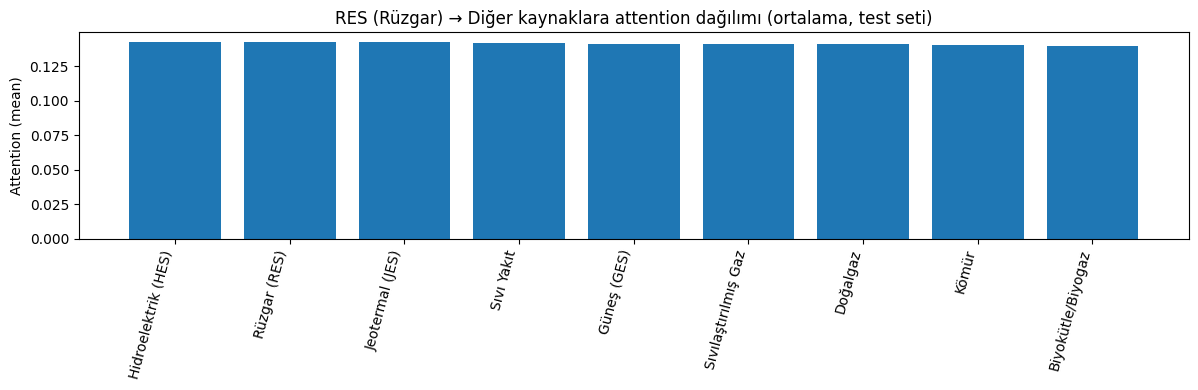

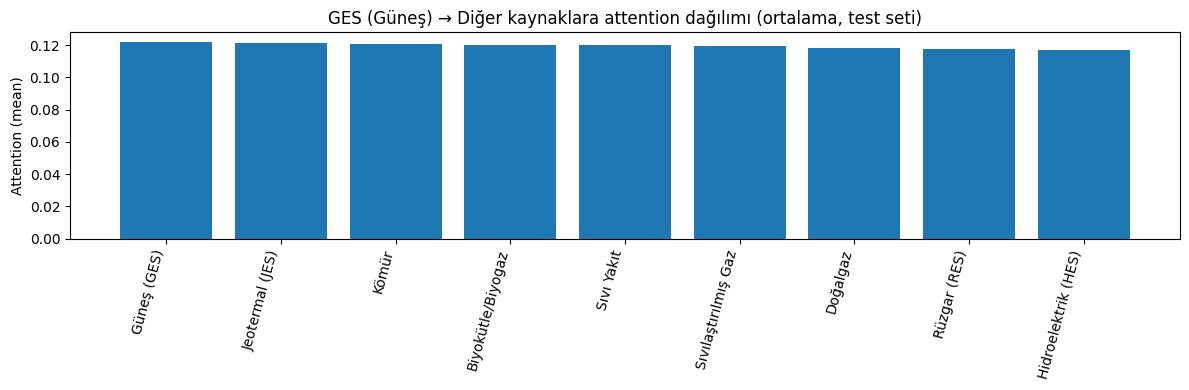

Top-5 RES -> [('Hidroelektrik (HES)', 0.14244518523904248), ('Rüzgar (RES)', 0.14242405355059745), ('Jeotermal (JES)', 0.1423081901672272), ('Sıvı Yakıt', 0.14205972406126863), ('Güneş (GES)', 0.14146817069099074)]
Top-5 GES -> [('Güneş (GES)', 0.12188456909641014), ('Jeotermal (JES)', 0.12124626852267294), ('Kömür', 0.12084989095986111), ('Biyokütle/Biyogaz', 0.12037279639656216), ('Sıvı Yakıt', 0.11993274744253841)]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

num_nodes = len(GEN_COLS)
node2idx = {n:i for i,n in enumerate(GEN_COLS)}
idx_RES = node2idx["Rüzgar (RES)"]
idx_GES = node2idx["Güneş (GES)"]

# Batch offset problemi olmasın diye batch_size=1
test_loader_1 = DataLoader(test_ds, batch_size=1, shuffle=False)

# RES -> dst attention biriktir
res_to_sum = np.zeros(num_nodes, dtype=np.float64)
res_to_cnt = np.zeros(num_nodes, dtype=np.float64)

# GES -> dst attention biriktir
ges_to_sum = np.zeros(num_nodes, dtype=np.float64)
ges_to_cnt = np.zeros(num_nodes, dtype=np.float64)

model.eval()
with torch.no_grad():
    for data in test_loader_1:
        data = data.to(device)

        # 1. katman attention
        _, (eidx, alpha) = model.gat1(data.x, data.edge_index, return_attention_weights=True)

        # alpha: (E, heads) -> head ortalaması
        if alpha.dim() == 2:
            a = alpha.mean(dim=1).detach().cpu().numpy()
        else:
            a = alpha.view(-1).detach().cpu().numpy()

        src = eidx[0].detach().cpu().numpy()
        dst = eidx[1].detach().cpu().numpy()

        # RES kaynaklı edge'ler
        mask_res = (src == idx_RES)
        np.add.at(res_to_sum, dst[mask_res], a[mask_res])
        np.add.at(res_to_cnt, dst[mask_res], 1)

        # GES kaynaklı edge'ler
        mask_ges = (src == idx_GES)
        np.add.at(ges_to_sum, dst[mask_ges], a[mask_ges])
        np.add.at(ges_to_cnt, dst[mask_ges], 1)

# Ortalama attention (RES->dst, GES->dst)
res_to_mean = res_to_sum / np.maximum(res_to_cnt, 1)
ges_to_mean = ges_to_sum / np.maximum(ges_to_cnt, 1)

# Self-loop'u istersen çıkar (yorumlaması daha temiz olur)
# res_to_mean[idx_RES] = 0
# ges_to_mean[idx_GES] = 0

# Sıralama: en çok attention alan hedefler
order_res = np.argsort(res_to_mean)[::-1]
order_ges = np.argsort(ges_to_mean)[::-1]

# ---- Plot: RES dağılımı
plt.figure(figsize=(12,4))
plt.bar([GEN_COLS[i] for i in order_res], res_to_mean[order_res])
plt.xticks(rotation=75, ha="right")
plt.title("RES (Rüzgar) → Diğer kaynaklara attention dağılımı (ortalama, test seti)")
plt.ylabel("Attention (mean)")
plt.tight_layout()
plt.show()

# ---- Plot: GES dağılımı
plt.figure(figsize=(12,4))
plt.bar([GEN_COLS[i] for i in order_ges], ges_to_mean[order_ges])
plt.xticks(rotation=75, ha="right")
plt.title("GES (Güneş) → Diğer kaynaklara attention dağılımı (ortalama, test seti)")
plt.ylabel("Attention (mean)")
plt.tight_layout()
plt.show()

# İstersen top-5 hedefleri yazdır
top5_res = [(GEN_COLS[i], float(res_to_mean[i])) for i in order_res[:5]]
top5_ges = [(GEN_COLS[i], float(ges_to_mean[i])) for i in order_ges[:5]]

print("Top-5 RES ->", top5_res)
print("Top-5 GES ->", top5_ges)


Eğitim Döngüsü

In [22]:
import os

os.makedirs("results/figures", exist_ok=True)
print("results/figures hazır")


results/figures hazır


Eğitim döngüsünü LOG

In [23]:
train_loss_hist = []
rmse_hist = []
mae_hist  = []
r2_hist   = []

EPOCHS = 25

for ep in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0

    for data in train_loader:
        data = data.to(device)
        opt.zero_grad()
        p = model(data)
        loss = F.mse_loss(p, data.y.squeeze(-1))
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_loss_hist.append(epoch_loss)

    # ---- test evaluation ----
    y_s, p_s = run_eval(test_loader)

    # scaled -> gerçek
    y_real = y_scaler.inverse_transform(y_s.reshape(-1,1)).reshape(-1)
    p_real = y_scaler.inverse_transform(p_s.reshape(-1,1)).reshape(-1)

    mse = mean_squared_error(y_real, p_real)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_real, p_real)
    r2   = r2_score(y_real, p_real)

    rmse_hist.append(rmse)
    mae_hist.append(mae)
    r2_hist.append(r2)

    print(f"Epoch {ep:02d} | loss {epoch_loss:.4f} | RMSE {rmse:.2f} | MAE {mae:.2f} | R2 {r2:.3f}")


Epoch 01 | loss 0.3712 | RMSE 483.30 | MAE 359.60 | R2 0.393
Epoch 02 | loss 0.3577 | RMSE 476.49 | MAE 351.01 | R2 0.410
Epoch 03 | loss 0.3597 | RMSE 476.66 | MAE 338.54 | R2 0.409
Epoch 04 | loss 0.3561 | RMSE 472.09 | MAE 341.14 | R2 0.421
Epoch 05 | loss 0.3544 | RMSE 486.87 | MAE 361.17 | R2 0.384
Epoch 06 | loss 0.3466 | RMSE 472.25 | MAE 335.38 | R2 0.420
Epoch 07 | loss 0.3306 | RMSE 495.86 | MAE 366.49 | R2 0.361
Epoch 08 | loss 0.3462 | RMSE 476.83 | MAE 353.58 | R2 0.409
Epoch 09 | loss 0.3188 | RMSE 493.82 | MAE 358.58 | R2 0.366
Epoch 10 | loss 0.3251 | RMSE 471.39 | MAE 330.46 | R2 0.422
Epoch 11 | loss 0.3065 | RMSE 484.67 | MAE 360.48 | R2 0.389
Epoch 12 | loss 0.3126 | RMSE 518.86 | MAE 390.52 | R2 0.300
Epoch 13 | loss 0.3369 | RMSE 467.87 | MAE 335.42 | R2 0.431
Epoch 14 | loss 0.3093 | RMSE 484.45 | MAE 346.59 | R2 0.390
Epoch 15 | loss 0.2954 | RMSE 500.15 | MAE 373.20 | R2 0.350
Epoch 16 | loss 0.2955 | RMSE 505.85 | MAE 382.60 | R2 0.335
Epoch 17 | loss 0.2939 |

Loss Curve

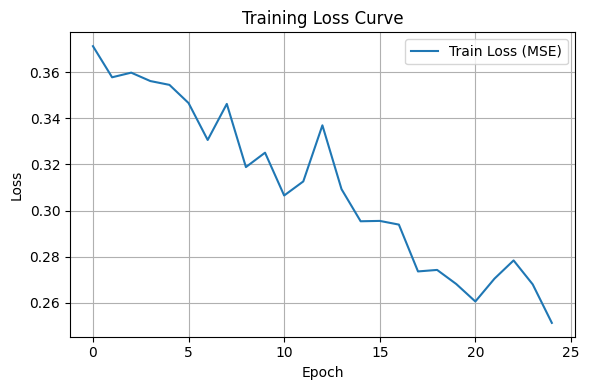

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="Train Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/figures/loss_curve.png", dpi=150)
plt.show()


RMSE / MAE Eğrileri

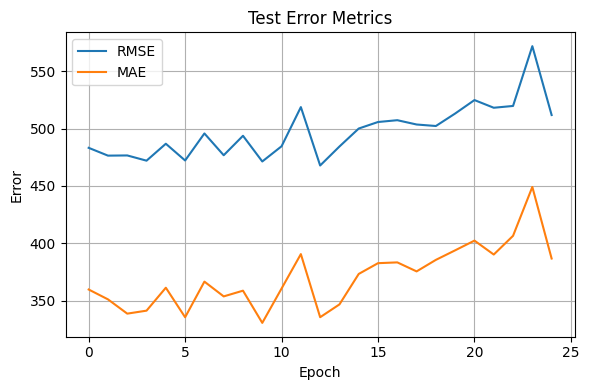

In [25]:
plt.figure(figsize=(6,4))
plt.plot(rmse_hist, label="RMSE")
plt.plot(mae_hist, label="MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Test Error Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/figures/error_metrics_curve.png", dpi=150)
plt.show()


R² Eğrisi

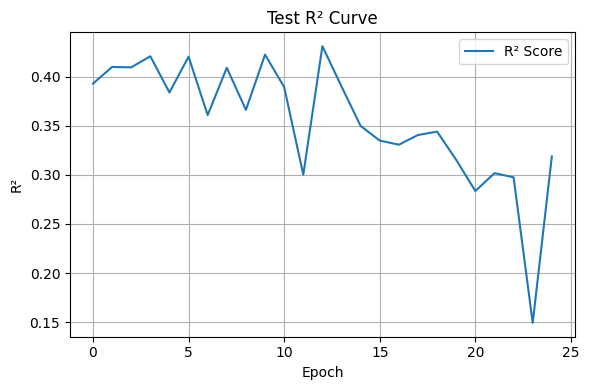

In [26]:
plt.figure(figsize=(6,4))
plt.plot(r2_hist, label="R² Score")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("Test R² Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/figures/r2_curve.png", dpi=150)
plt.show()


JSON olarak kaydı

In [27]:
import json

metrics = {
    "final_rmse": rmse_hist[-1],
    "final_mae": mae_hist[-1],
    "final_r2": r2_hist[-1],
    "rmse_per_epoch": rmse_hist,
    "mae_per_epoch": mae_hist,
    "r2_per_epoch": r2_hist
}

with open("results/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("metrics.json kaydedildi")


metrics.json kaydedildi


GİTHUB Bağlantısı